In [1]:
#|default_exp comparison_space
## Standard libraries
import os
import math
import numpy as np
import time
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## project specifics
import diffusion_curvature
from diffusion_curvature.kernels import *
from diffusion_curvature.datasets import *
import jax
import jax.numpy as jnp
jax.devices()

%load_ext autoreload
%autoreload 2

/tmp/ipykernel_514361/1148968908.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


# Implementation (PyGSP + JAX)
> Curvature computations on any graphtools graph

This notebook implements diffusion curvature atop the popular PyGSP library. To compute the curvature of any PyGSP graph, simply instantiate a `DiffusionCurvature` object with your choice of parameters, and pass the graphtools graph through as input.

What follows is a literate implementation, showing the steps of the algorithm applied to our old friend, the torus.

The implementation of Diffusion Curvature involves several big pieces, each of which can be performed with different strategies:

1. Simulating heat diffusion on the manifold, either via powering the diffusion matrix, or by Chebyshev approximation of the heat equation using the graph laplacian.
2. Computing the "spreads" of diffusion. This can be done either via the entropy or the Wasserstein distance.
3. Constructing a comparison space of approximately the same sampling as the input graph.
4. (Experimental) Verification that the above is working by differentiating the spreads of diffusion over time.

We implement everything generically in JAX (a high performance numpy replacement, which can compile to the GPU), treating each of the above as modules that can be parametrically tuned. Functional programming is our game: each function takes a graph object as input and returns an updated graph object with the required quantities computed. 

In [2]:
# Our sample dataset for testing the rest of the notebook
from diffusion_curvature.datasets import torus
X_torus, ks_torus = torus(5000,use_guide_points=True)

# Graph Construction
Our 'Graphs' notebook has code to create PyGSP graphs from pointcloud data, in several varieties. 
We also provide heuristics to sanity check the graphs, as well as choose the optimal parameters.
TODO: MAKE THESE HEURISTICS

In [3]:
from diffusion_curvature.graphs import get_alpha_decay_graph, get_knn_graph, get_scanpy_graph
G_torus = get_alpha_decay_graph(X_torus,knn=15,decay=20,anisotropy=1.0)

# The Diffusion Curvature Class

In [4]:
#| export
import pygsp
import jax
import jax.numpy as jnp
from fastcore.all import *
import skdim
from inspect import getfullargspec
from typing import Callable, Literal, get_args, get_origin
from tqdm.auto import trange, tqdm
from jax.experimental import sparse

from diffusion_curvature.graphs import diff_aff, diff_op
from diffusion_curvature.heat_diffusion import heat_diffusion_on_signal, kronecker_delta, jax_power_matrix
from diffusion_curvature.diffusion_laziness import wasserstein_spread_of_diffusion, entropy_of_diffusion
from diffusion_curvature.distances import phate_distances_differentiable
from diffusion_curvature.comparison_space import EuclideanComparisonSpace, fit_comparison_space_model
import diffusion_curvature


_DIFFUSION_TYPES = Literal['diffusion matrix','heat kernel']
_LAZINESS_METHOD = Literal['Wasserstein','Entropic']
_COMPARISON_METHOD = Literal['Ollivier', 'Subtraction']

class DiffusionCurvature():
    def __init__(
            self,
            diffusion_type:_DIFFUSION_TYPES = 'diffusion matrix', # Either ['diffusion matrix','heat kernel']
            laziness_method: _LAZINESS_METHOD = 'Wasserstein', # Either ['Wasserstein','Entropic']
            comparison_method: _COMPARISON_METHOD = 'Ollivier',
            dimest = None, # Dimension estimator to use. If none, defaults to kNN.
            different_comparison_space_for_each_point = True, # If true, constructs a comparison space for every point in the manifold. If false, only constructs unique comparison spaces for each unique dimension.
    ):
        store_attr()
        self.D = None
        if self.dimest is None:
            self.dimest = skdim.id.KNN()
    def unsigned_curvature(
            self,
            G:pygsp.graphs.Graph, # PyGSP input Graph
            t:int, # Scale at which to compute curvature; number of steps of diffusion.
            idx=None, # the index at which to compute curvature. If None, computes for all points. TODO: Implement
            # The below are used internally
            _also_return_first_scale = False, # if True, calculates the laziness measure at both specified t and t=1. The distances (if used) are calcualted with the larger t.
            D = None, # Supply manifold distances yourself to override their computation. Only used with the Wasserstein laziness method.
    ):
        n = G.L.shape[0]
        # Compute diffusion matrix
        match self.diffusion_type:
            case 'diffusion matrix':
                P = diff_op(G).todense() # is sparse, by default
                P = jnp.array(P)
                Pt = jax_power_matrix(P,t)
            case 'heat kernel':
                signal = jnp.eye(n) if idx is not None else kronecker_delta(n,idx=idx)
                Ps = heat_diffusion_on_signal(G, signal, [1,t])
                P = Ps[0]
                Pt = Ps[1]
            case _:
                raise ValueError(f"Diffusion Type {self.diffusion_type} not in {_DIFFUSION_TYPES}")
        match self.laziness_method:
            case "Wasserstein":
                if D is None: D = phate_distances_differentiable(Pt) #TODO: Could be more efficient here if there's an idx
                print(D[0])
                laziness = wasserstein_spread_of_diffusion(D,Pt) if idx is None else wasserstein_spread_of_diffusion(D[idx],Pt[idx])
                if _also_return_first_scale: laziness_nought = wasserstein_spread_of_diffusion(D,P)
            case "Entropic":
                laziness = entropy_of_diffusion(Pt) if idx is None else entropy_of_diffusion(Pt[idx])
                if _also_return_first_scale: laziness_nought = entropy_of_diffusion(P)
            case _:
                raise ValueError(f"Laziness Method {self.laziness_method} not in {_LAZINESS_METHOD}")
        if _also_return_first_scale: 
            return laziness, laziness_nought
        else:
            return laziness
    def curvature(
            self,
            G:pygsp.graphs.Graph, # Input Graph
            t:int, # Scale
            idx=None, # the index at which to compute curvature. If None, computes for all points.
            dim = None, # the INTRINSIC dimension of your manifold, as an int for global dimension or list of pointwise dimensions; if none, tries to estimate pointwise.
    ):
        def fit_comparison_space(dimension, jump_of_diffusion, num_points_in_comparison):
            model = EuclideanComparisonSpace(dimension=dimension, num_points=num_points_in_comparison, jump_of_diffusion=jump_of_diffusion)
            params = fit_comparison_space_model(model, max_epochs=1000)
            euclidean_stuffs = model.apply(params) # dictionary containing A, P, D
            W = fill_diagonal(euclidean_stuffs['A'],0)
            G_euclidean = pygsp.graphs.Graph(
                W = W,
                lap_type = G.lap_type, # type of laplacian; we'll use the same as inputted.
                )
            return G_euclidean, euclidean_stuffs['D']


        # Start by estimating the manifold's unsigned curvature, i.e. spreads of diffusion
        manifold_spreads, manifold_spreads_nought = self.unsigned_curvature(G,t,idx, _also_return_first_scale=True)

        n = G.L.shape[0]
        if dim is None: # The dimension wasn't supplied; we'll estimate it pointwise
            print("estimating local dimension of each point... may take a while")
            ldims = self.dimest.fit_pw(
                                G.data, #TODO: Currently this requires underlying points!
                                n_neighbors = 100,
                                n_jobs = 1)
            dims_per_point = np.round(ldims.dimension_pw_).astype(int)
        else: # the dimension *was* supplied, but it may be either a single global dimension or a local dimension for each point
            if isinstance(dim, int):
                dims_per_point = np.ones(G.P.shape[0], dtype=int)*dim
            else:
                dims_per_point = dim
        
        flat_spreads = jnp.zeros(n)
        num_points_in_comparison = n // 5 # TODO: Can surely find a better heuristic here

        if self.different_comparison_space_for_each_point:
            # iterate through each point, extract single step spread of diffuusion, erect comparison space tailored to that point
            for i in trange(n):
                G_euclidean, euclidean_D = fit_comparison_space(
                    dimension = dims_per_point[i],
                    jump_of_diffusion = manifold_spreads[i],
                    num_points_in_comparison = num_points_in_comparison,
                    )
                fs = self.unsigned_curvature(G_euclidean,t,idx=0,D=euclidean_D)
                flat_spreads = flat_spreads.at[i].set(
                    fs
                )
        else:
            raise NotImplementedError # TODO: Implement this! Need to average spreads of all points of a dimension. Create a mapping
            # between points and dimensions to get an easy mask of points per dimension. Use this to replace the set stuff below.
            unique_dims = set(dims_per_point)
            unique_flat_lazinesses = {}
            for d in unique_dims:
                G_euclidean, euclidean_D = fit_comparison_space(
                    dimension = d,
                    jump_of_diffusion = manifold_spreads[i], # Need average spreads in dimension
                    num_points_in_comparison = num_points_in_comparison,
                    )
                flat_spreads = flat_spreads.at[i].set(
                    self.unsigned_curvature(G_euclidean,t,idx=0,D=euclidean_D)
                )

                G_flat = euclidean_comparison_space(G, dimension=d)
                G_flat = self.power_diffusion_matrix(G_flat,t)
                unique_flat_lazinesses = self.unsigned_curvature(G_flat, t, idx=0)

        match self.comparison_method:
            case "Ollivier":
                ks = 1 - manifold_spreads/flat_spreads
            case "Subtraction":
                ks = flat_spreads - manifold_spreads
            case _:
                raise ValueError(f'Comparison method must be in {_COMPARISON_METHOD}')    
        return ks    
    
def fill_diagonal(a, val):
  assert a.ndim >= 2
  i, j = jnp.diag_indices(min(a.shape[-2:]))
  return a.at[..., i, j].set(val)
        

In [5]:
X_plane = plane(1000)
G_plane = get_alpha_decay_graph(X_plane, decay=20, knn=10, anisotropy=0.5)
DC = DiffusionCurvature(laziness_method="Entropic")
ks_plane = DC.curvature(G_plane, t=8, dim=2)

  0%|          | 0/1001 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from diffusion_curvature.distances import pairwise_euclidean
euclidean_d = pairwise_euclidean(X_plane, X_plane)[0]

In [ ]:
ks_plane

Array([-45.10387 , -22.97511 , -41.056095, ..., -37.09275 , -30.838621,
       -43.337597], dtype=float32)

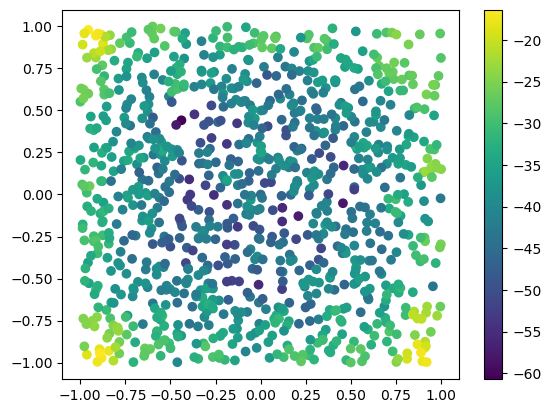

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(X_plane[:,0],X_plane[:,1], c = ks_plane)
plt.colorbar()

In [ ]:
DC.unsigned_curvature(G_plane, t=8)

[  0.       95.41384  88.0906  ... 117.37426 125.99906 100.1335 ]


Array([26.26042 , 29.784418, 29.83345 , ..., 24.870432, 30.061592,
       30.38324 ], dtype=float32)

In [ ]:
P = diff_op(G_plane).todense() # is sparse, by default
P = jnp.array(P)
Pt = jax_power_matrix(P,8)

In [ ]:
phate_d = phate_distances_differentiable(Pt)

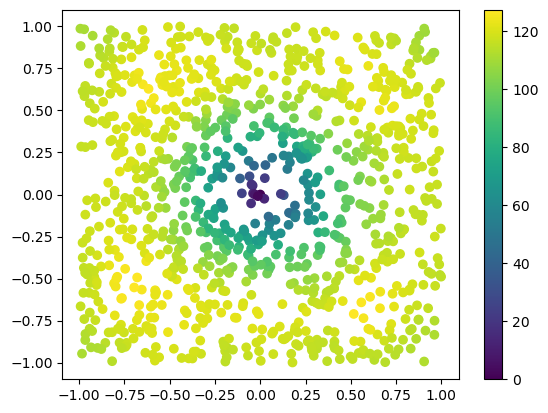

In [ ]:
plt.scatter(X_plane[:,0],X_plane[:,1], c = phate_d[0])
plt.colorbar()

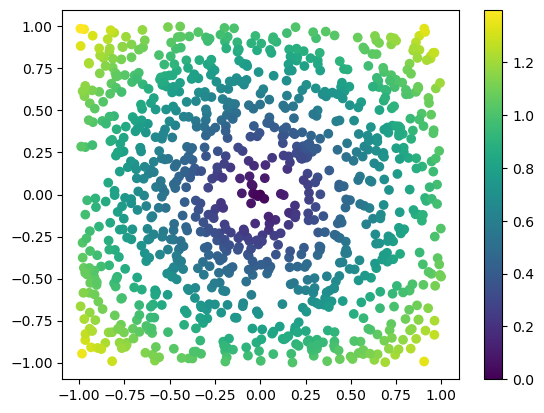

In [ ]:
plt.scatter(X_plane[:,0],X_plane[:,1], c = euclidean_d)
plt.colorbar()